<a href="https://colab.research.google.com/github/RaulMrSouza/Bollinger-Buy/blob/master/Bollinger_Buy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [274]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
from datetime import date, timedelta
import numpy as np

df = web.DataReader("PETR4.SA", 'yahoo', date.today() - timedelta(days=360), date.today())
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-05-06,18.059999,17.280001,17.870001,17.280001,67937500.0,17.280001
2020-05-07,17.870001,17.350000,17.750000,17.440001,81265100.0,17.440001
2020-05-08,18.580000,17.709999,17.740000,18.480000,83232700.0,18.480000
2020-05-11,18.930000,18.110001,18.299999,18.180000,61424000.0,18.180000
2020-05-12,0.000000,0.000000,0.000000,18.139999,0.0,18.139999


In [0]:
df['30 Day MA'] = df['Close'].rolling(window=20).mean()
df['30 Day STD'] = df['Close'].rolling(window=20).std() 
    
df['Upper'] = df['30 Day MA'] + (df['30 Day STD'] * 2)
df['Lower'] = df['30 Day MA'] - (df['30 Day STD'] * 2)

In [0]:

df = df[20:]

df['B'] =  ((df['Close'] >=  df['Lower']) & (df['Close'] >  df['Open']) & (df['Close'].shift(periods=1) <  df['Open'].shift(periods=1)) & (df['Close'].shift(periods=1) <  df['Lower'].shift(periods=1))  & (df['Volume'] > df['Volume'].shift(periods=1) )) 
df = df.assign(Buy=np.where(df['B'] , df['Lower'], float("NaN")))

df['S'] =  ((df['Close'] <=  df['Upper']) & (df['Close'] <=  df['Open']) & (df['Close'].shift(periods=1) >  df['Open'].shift(periods=1)) & (df['Close'].shift(periods=1) >  df['Upper'].shift(periods=1))  & (df['Volume'] > df['Volume'].shift(periods=1) )) 
df = df.assign(Sell=np.where(df['S'] , df['Upper'], float("NaN")))

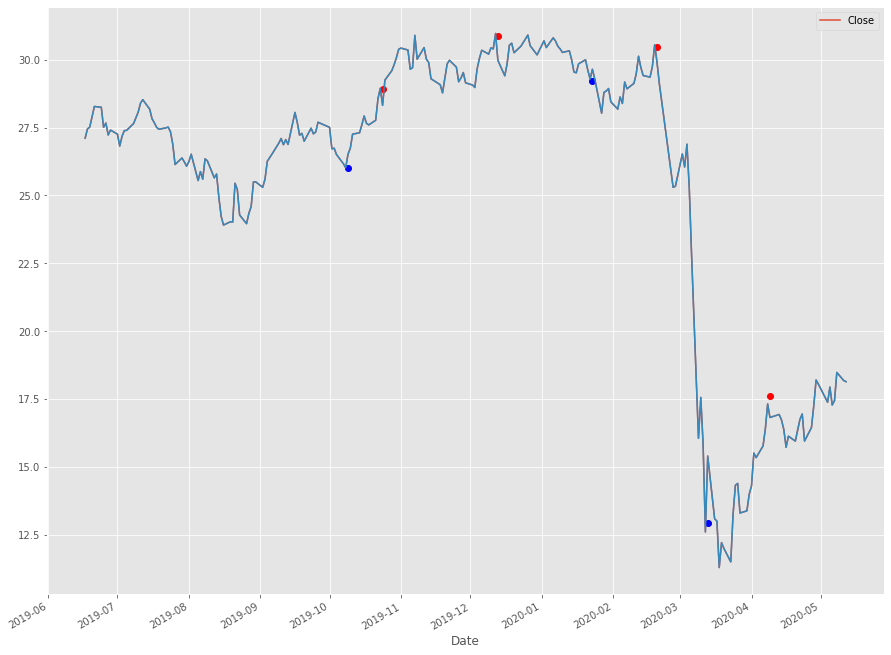

In [277]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(15, 12))

p = df[['Close']].plot()
df['Buy'].plot(label='Buy', linestyle='--', marker='o', color='b')
df['Sell'].plot(label='Sell', linestyle='--', marker='o', color='r')
df['Close'].plot(label='Close')